# Estimando o impacto do coronavírus no mercado brasileiro

O objetivo desse projeto é analisar o impacto gerado pelo pandemia do coronavírus no mercado de ações do Brasil. Para isso usaremos uma biblioteca do python chamada **casualimpact**. A ideia é que a pandemia serve com um tipo de intervenção no mercado e toda intervenção pode gerar ou não impactos significativos após sua aplicação.

Para analisarmos o impacto de uma intervenção devemos, também, gerar um cenário contrafactual, que seria aquilo que teria acontecido caso a intervenção não tivesse ocorrido e, após isso compararmos os resultados antes e depois no tempo.

Nesse projeto iremos usar uma modelagem **ARIMA** para estimarmos um cenário contrafactual. Esse cenário contrafactual serão as previsões geradas por esse modelo ARIMA até a data final dos dados. O modelo será treinado com dados de 2019 e serão geradas previsões para o anos de 2020. Como a metodologia Box-Jenkins (usada na modelagem ARIMA) é um pouco extensa usaremos uma biblioteca de séries temporais no python que gera o modelo automaticamente (**autoARIMA**) apenas com a adição de parâmetros.

Para esse projeto, especificamente, vamos supor que a intervenção foi gerada apenas pela pandemia do coronavírus.

# O que é o IBOVESPA?

É um índice que mede o desempenho médio das ações mais negociadas, nos últimos meses, na Bolsa de Valores do Brasil (a B3); as ações que compõem esse índice correspondem a 80% das negociações que acontecem na Bolsa de Valores. O índice existe a mais de 50 anos e ao todo e serve como parâmetro de análise do mercado de capitais brasileiro.

# Sobre os dados

A base de dados apresenta 6 séries temporais: o índice BOVESPA de abertura, o IBOVESPA de alta, o IBOVESPA de baixa, o IBOVESPA de fechamento, o IBOVESPA ajustado e o Volume negociado. Para nossa análise usaremos apenas o IBOVESPA de fechamento.

# Importando bibliotecas

In [1]:
#Bibliotecas de análise de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#autoARIMA
from pmdarima.arima import auto_arima

#análise causal
from causalimpact import CausalImpact

# Importando os dados

In [2]:
bolsa=pd.read_csv("^BVSP.csv")

In [3]:
#Visualizando as primeiros linhas do dataset
bolsa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,97828.0,97856.0,96782.0,97467.0,97467.0,3584000.0
1,2019-06-11,97467.0,98985.0,97467.0,98960.0,98960.0,4922400.0
2,2019-06-12,98960.0,99240.0,97831.0,98321.0,98321.0,4948800.0
3,2019-06-13,98321.0,99364.0,98321.0,98774.0,98774.0,5594000.0
4,2019-06-14,98776.0,98981.0,97601.0,98040.0,98040.0,9184900.0


In [4]:
#Observando as últimas linhas do dataset
bolsa.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
242,2020-06-01,87395.0,89019.0,86837.0,88620.0,88620.0,9849400.0
243,2020-06-02,88622.0,91046.0,88622.0,91046.0,91046.0,11827300.0
244,2020-06-03,91048.0,93710.0,91048.0,93002.0,93002.0,15137900.0
245,2020-06-04,92993.0,94132.0,92221.0,93829.0,93829.0,11488000.0
246,2020-06-05,93839.0,97356.0,93839.0,94637.0,94637.0,13320300.0


In [5]:
#Indexanço os dados pelo tempo
dateparse= lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
bolsa=pd.read_csv('^BVSP.csv',parse_dates=['Date'],index_col='Date',date_parser=dateparse)

In [6]:
#Antes tínhamos 7 colunas, agora temos 6 colunas indexidas no tempo
bolsa.shape

(247, 6)

In [7]:
#visualizando novamente as colunas do dataset
bolsa.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-10,97828.0,97856.0,96782.0,97467.0,97467.0,3584000.0
2019-06-11,97467.0,98985.0,97467.0,98960.0,98960.0,4922400.0
2019-06-12,98960.0,99240.0,97831.0,98321.0,98321.0,4948800.0
2019-06-13,98321.0,99364.0,98321.0,98774.0,98774.0,5594000.0
2019-06-14,98776.0,98981.0,97601.0,98040.0,98040.0,9184900.0


In [8]:
#Tabela com estatísticas descritiva dos dados
bolsa.describe()

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.000000,246.000000,2.460000e+02
mean,99962.227642,101106.487805,98809.390244,99976.276423,99976.276423,6.789785e+06
std,13524.927222,12946.573470,14044.902104,13550.059295,13550.059295,3.269044e+06
min,63604.000000,67604.000000,61691.000000,63570.000000,63570.000000,0.000000e+00
25%,96643.750000,97879.750000,94343.000000,95085.250000,95085.250000,4.515425e+06
50%,103489.500000,104218.000000,102702.000000,103492.000000,103492.000000,5.487100e+06
75%,108366.000000,108887.250000,107425.000000,108390.000000,108390.000000,8.870625e+06
max,119528.000000,119593.000000,118108.000000,119528.000000,119528.000000,1.675150e+07


In [9]:
#Visualizando se há vissing values

#cada séries possui um missing values
bolsa.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [10]:
#excluindo os missing values
bolsa=bolsa.dropna()

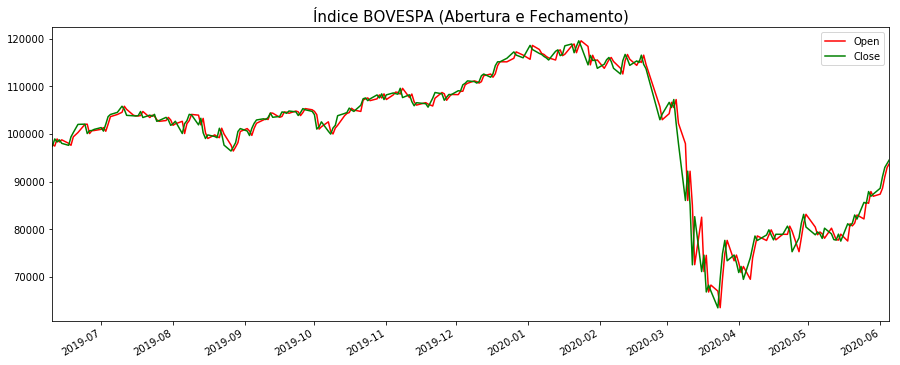

In [11]:
#Plotando gráfico de série temporal para as séries de abertura e de fechamento
plt.figure(figsize=(15,6))
bolsa['Open'].plot(color='r')
bolsa['Close'].plot(color='g')
plt.xlabel('')
plt.title('Índice BOVESPA (Abertura e Fechamento)',size=15)
plt.legend()
plt.show()

#podemos ver nitidamente a queda no ano de 2020

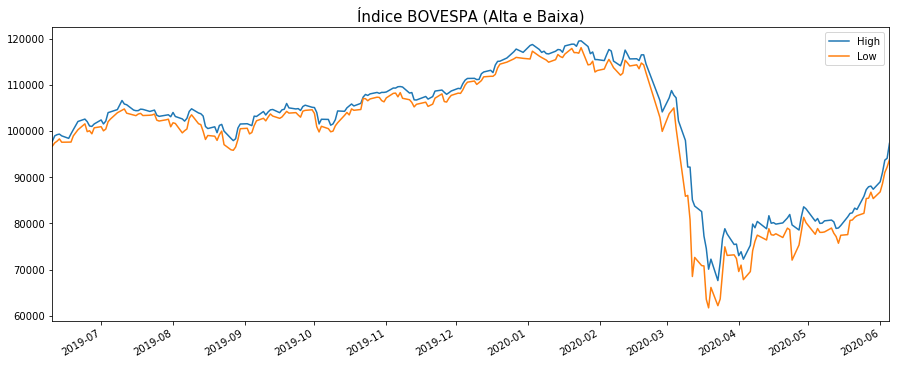

In [12]:
#Plotando gráfico de série de tempo de alta e baixa
plt.figure(figsize=(15,6))
bolsa['High'].plot()
bolsa['Low'].plot()
plt.xlabel('')
plt.title('Índice BOVESPA (Alta e Baixa)',size=15)
plt.legend()
plt.show()

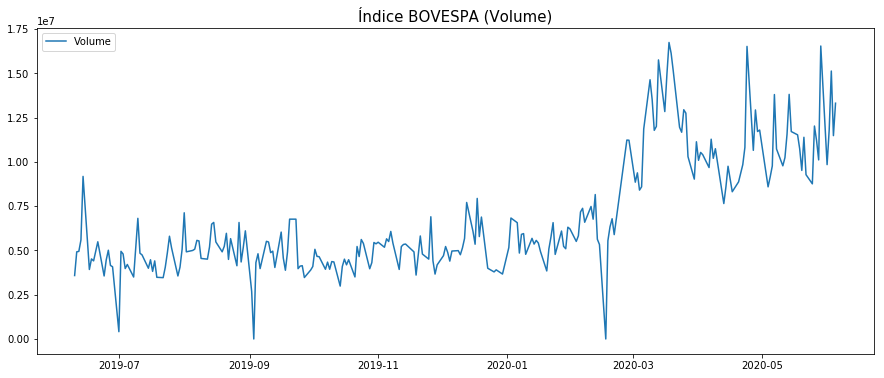

In [40]:
#Plotando gráfico de série de tempo de alta e baixa
plt.figure(figsize=(15,6))
plt.plot(bolsa['Volume'])
plt.xlabel('')
plt.title('Índice BOVESPA (Volume)',size=15)
plt.legend()
plt.show()

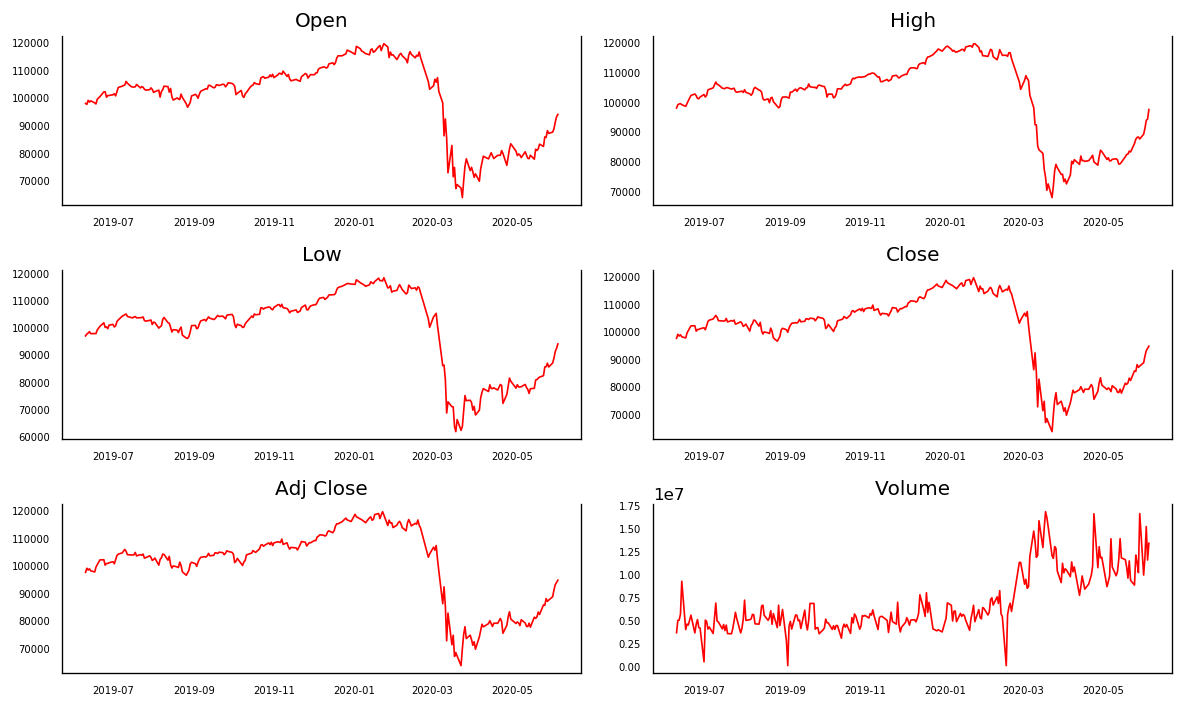

In [13]:
#vamos criar 6 gráficos (3 linhas e 2 colunas) com as séries temporais
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = bolsa[bolsa.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(bolsa.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#Abaixo podemos ver as séries de abertura, alta, baixa, fechamento, ajustamento e volume.
#Com exceção da séries de volume, as outras são muito semelhantes

# Estimando uma contrafactual

Como já falado anteriormente, iremos utilizar um modelo ARIMA (autorregressivo integrado com médias móveis) para gerarmos um cenário contrafactual. Novamente, um cenário contrafactual é um cenário que ocorreria caso não houve uma intervenção na variável de estudo, que no nosso caso é o índice BOVESPA. Esse cenário estaria sob uma condição *ceteris paribus* (tudo mais constante), isto é, consideramos que as condições de mercado não se alteram.

O modelo ARIMA gerará previsões que servirão como o cenário contrafactual. O autoARIMA irá fazer toda a metodologia Box-Jenkins.

In [15]:
#Para a escolha da variável, vamos escolher a variável de fechamento do índice BOVESPA
#que é o resultado final do índice no final do dia
data=bolsa['Close']

In [16]:
#Vamos agora aplicar a modelagem autoARIMA

#Esse tipo de modelagem irá treinar várias combinações e gerará vários modelos arima

#Para esse modelo irei aplicar os parâmetros de start (p,q), de max(p,q) e de diferenciação e diferenciação sazonal

stepwise=auto_arima(data,start_p=1,start_q=1,max_p=6,max_q=6,m=12,start_P=0,seasonal=True,d=1,D=1,trace=True,
                    error_action='ignore',suppress_warnings=True,stepwise=False)

#Abaixo podemos ver os modelos gerados

Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=4437.985, BIC=4444.887, Time=1.183 seconds
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; AIC=4422.655, BIC=4433.008, Time=0.537 seconds
Fit ARIMA(0,1,0)x(0,1,2,12) [intercept=True]; AIC=4408.446, BIC=4422.250, Time=0.994 seconds
Fit ARIMA(0,1,0)x(1,1,0,12) [intercept=True]; AIC=4426.955, BIC=4437.308, Time=0.269 seconds
Fit ARIMA(0,1,0)x(1,1,1,12) [intercept=True]; AIC=4395.989, BIC=4409.794, Time=1.420 seconds
Fit ARIMA(0,1,0)x(1,1,2,12) [intercept=True]; AIC=4405.096, BIC=4422.351, Time=1.287 seconds
Fit ARIMA(0,1,0)x(2,1,0,12) [intercept=True]; AIC=4418.366, BIC=4432.170, Time=0.523 seconds
Fit ARIMA(0,1,0)x(2,1,1,12) [intercept=True]; AIC=4401.631, BIC=4418.886, Time=2.461 seconds
Fit ARIMA(0,1,0)x(2,1,2,12) [intercept=True]; AIC=4403.243, BIC=4423.949, Time=4.313 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=4439.181, BIC=4449.535, Time=0.062 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=4423.606, BIC=4437.4

Fit ARIMA(3,1,1)x(1,1,0,12) [intercept=True]; AIC=4429.718, BIC=4453.875, Time=2.363 seconds
Fit ARIMA(3,1,2)x(0,1,0,12) [intercept=True]; AIC=4433.887, BIC=4458.044, Time=0.988 seconds
Fit ARIMA(4,1,0)x(0,1,0,12) [intercept=True]; AIC=4443.371, BIC=4464.077, Time=0.148 seconds
Fit ARIMA(4,1,0)x(0,1,1,12) [intercept=True]; AIC=4427.799, BIC=4451.956, Time=0.560 seconds
Fit ARIMA(4,1,0)x(1,1,0,12) [intercept=True]; AIC=4432.112, BIC=4456.269, Time=0.413 seconds
Fit ARIMA(4,1,1)x(0,1,0,12) [intercept=True]; AIC=4445.243, BIC=4469.401, Time=0.666 seconds
Fit ARIMA(5,1,0)x(0,1,0,12) [intercept=True]; AIC=4444.916, BIC=4469.074, Time=0.152 seconds
Total fit time: 128.809 seconds


In [17]:
#Para a escolha do modelo eu irei usar o critério de informação AIC (também poderia usar o critério BIC, mas geralmente o AIC
#é um critério melhor) e serão usados os modelos com os menores critérios de informação.
display(stepwise.aic())
display(stepwise.bic())

#Abaixo podemos ver os critério AIC e BIC, respectivamente. 

4395.989471036653

4409.793624850916

O modelo escolhido pelos critério foi o modelo ARIMA(0,1,0)x(1,1,1,12).

É um modelo sem a ordem autorregressiva e sem a ordem de médias móveis, mas os parâmetros de sazonalidade são P,D e Q estão presentes no modelo, mostra que há presença de sazonalidade nos dados.

OBS: o motivo de escolher o modelo com menor AIC (ou BIC) ,é que usamos o princípio da parcimônia, ou seja, escolher o modelo que reduz os erros, porém é o mais simples.

# Treinando o modelo ARIMA

Vamos agora usar o modelo e treiná-lo com os dados. Para isso iremos separar os dados entre treino e teste.

In [19]:
#dados de treino

#vamos colocar os dados de treino de junho de 2019 até o final do ano de 2019
train=data.loc['2019-06-01':'2019-12-31']

#dados de teste irão do começo de 2020 em diante
test=data.loc['2020-01-01':]

In [20]:
#Treinando o modelo
stepwise.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [21]:
#Gerando as previsões (nossa contrafactual)

#Ao todo são 106 dias (do início do ano até  fim da série)
future_forecast=stepwise.predict(n_periods=106)

In [22]:
#transformando as previsões em dataframe
future_forecast=pd.DataFrame(future_forecast,index=test.index)

In [23]:
#Vamos agora criar uma nova série, em que concatenaremos os dados de 2019 com as previsões para 2020
pd.concat([test,future_forecast],axis=1).head(10)

,Close,0
Date,,
2020-01-02,118573.0,116262.389404
2020-01-03,117707.0,117432.775000
2020-01-06,116878.0,117870.344666
2020-01-07,116662.0,117266.900291
2020-01-08,116247.0,118031.534885
2020-01-09,115947.0,119661.719616
2020-01-10,115503.0,120460.284879
2020-01-13,117325.0,120556.023505
2020-01-14,117632.0,121307.520069


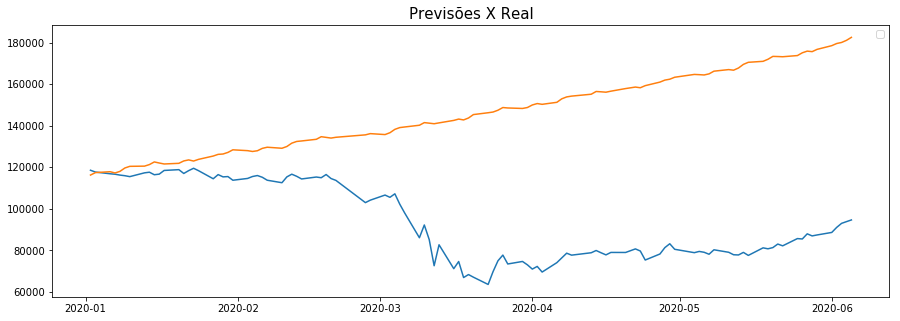

In [25]:
plt.figure(figsize=(15,5))
plt.plot(pd.concat([test,future_forecast],axis=1))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show()

#Em laranja podemos ver as previsões e em azul os valores reais

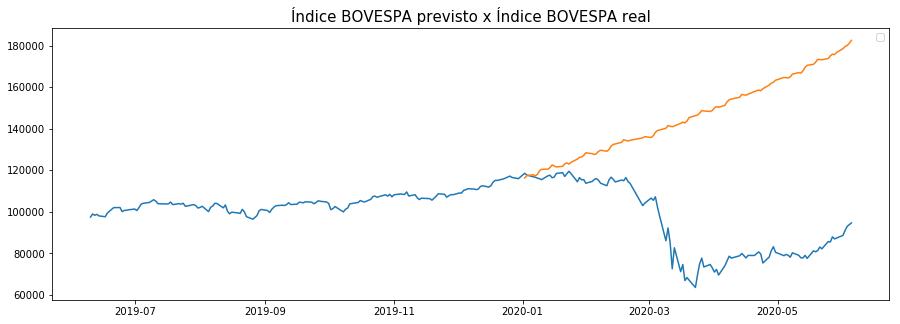

In [30]:
plt.figure(figsize=(15,5))
plt.plot(pd.concat([data,future_forecast],axis=1))
plt.legend('')
plt.xlabel('')
plt.title('Índice BOVESPA previsto x Índice BOVESPA real',size=15)
plt.show()
#Abaixo as séries completas
#podemos perceber que as previsões, de certa forma, fazem sentido

#Se nada tivesse ocorrido o índice BOVESPA seguiria em alta, no ano de 2020

In [31]:
#Criando uma nova coluna no dataset com os dados de treino
bolsa['previsão']=train.append(future_forecast)

In [218]:
bolsa.tail()

,Open,High,Low,Close,Adj Close,Volume,previsão
Date,,,,,,,
2020-06-01,87395.0,89019.0,86837.0,88620.0,88620.0,9849400.0,178586.721717
2020-06-02,88622.0,91046.0,88622.0,91046.0,91046.0,11827300.0,179620.049631
2020-06-03,91048.0,93710.0,91048.0,93002.0,93002.0,15137900.0,180130.635143
2020-06-04,92993.0,94132.0,92221.0,93829.0,93829.0,11488000.0,181156.268965
2020-06-05,93839.0,97356.0,93839.0,94637.0,94637.0,13320300.0,182588.871262


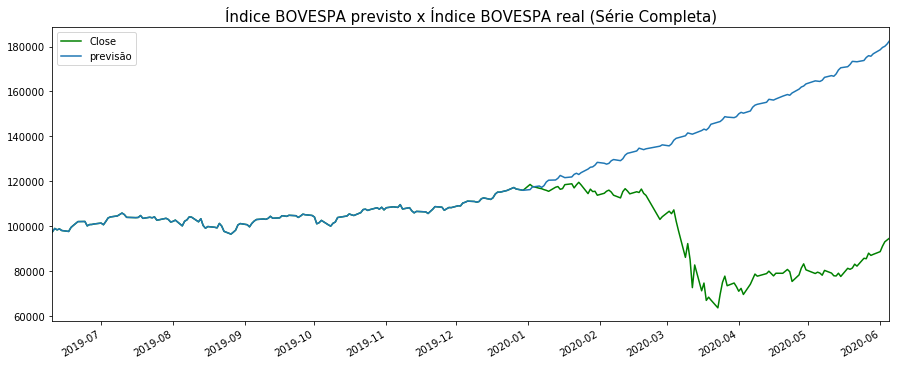

In [32]:
plt.figure(figsize=(15,6))
#bolsa['Open'].plot(color='r')
bolsa['Close'].plot(color='g')
bolsa['previsão'].plot()
plt.xlabel('')
plt.title('Índice BOVESPA previsto x Índice BOVESPA real (Série Completa)',size=15)
plt.legend()
plt.show()

In [33]:
#Vamos definir uma variável que irá receber os dados de fechamento e os dados com as previsões
impacto = pd.DataFrame({'Close': bolsa['Close'],'Previsão': bolsa['previsão']}, columns=['Close','Previsão'])

In [35]:
#Visualizando as 20 primeiras linhas desse dataset
impacto.head(20)

,Close,Previsão
Date,,
2019-06-10,97467.0,97467.0
2019-06-11,98960.0,98960.0
2019-06-12,98321.0,98321.0
2019-06-13,98774.0,98774.0
2019-06-14,98040.0,98040.0
2019-06-17,97623.0,97623.0
2019-06-18,99404.0,99404.0
2019-06-19,100303.0,100303.0
2019-06-21,102013.0,102013.0


In [37]:
#Irei definir agora 2 variáveis
#um do período pré-intervenção (quando não ocorre a pandemia)
#um do período pós intervenção

#anos de 2019
pre_period = ['2019-06-10','2019-12-30']

#ano de 2020
post_period = ['2020-01-02','2020-06-05']

In [38]:
#Aplicando a função CausalImpacto
ci = CausalImpact(impacto, pre_period, post_period)

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


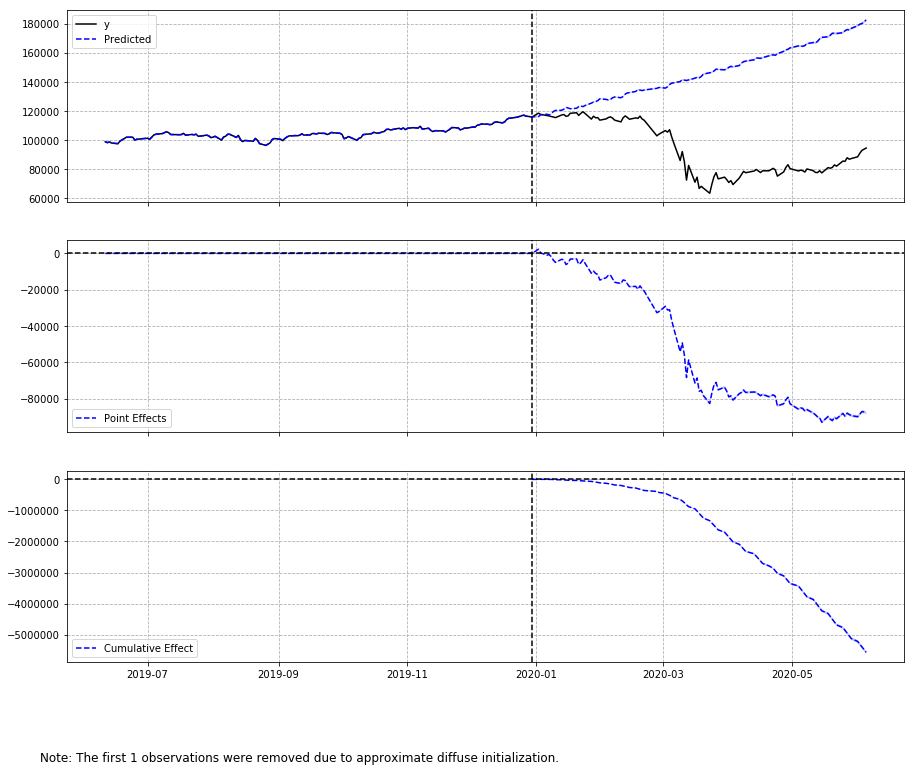

In [225]:
#gerando o gráfico de comparação do antes e depois da intervenção (ou da pandemia)
ci.plot()

In [224]:
#Abaixo podemos ver um relatório gerado por esse biblioteca
print(ci.summary())
print(ci.summary(output='report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    93766.75           9939275.0
Prediction (s.d.)         146317.38 (209.58) 15509641.92 (22215.1)
95% CI                    [145913.46, 146734.98][15466826.36, 15553907.95]

Absolute effect (s.d.)    -52550.63 (209.58) -5570366.92 (22215.1)
95% CI                    [-52968.24, -52146.71][-5614632.95, -5527551.36]

Relative effect (s.d.)    -35.92% (0.14%)    -35.92% (0.14%)
95% CI                    [-36.2%, -35.64%]  [-36.2%, -35.64%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 93766.75. By contrast, in the absence of an
intervention, we would have expected an average response of 146317.38.
The 95% interval of this counterfactual prediction is 

# **TRADUÇÃO DO RELATÓRIO**

Durante o período pós-intervenção, a variável resposta teve um valor médio de aprox. 93766.75. Por outro lado, na ausência de um intervenção (ou da pandemia), teríamos esperado uma resposta média de 146317.38. O intervalo de 95% dessa previsão contrafactual é **[145893.85, 146769.53]**. Subtrair essa previsão da resposta observada produz uma estimativa do efeito causal que a intervenção teve no resposta variável. Esse efeito é **-52550.63** com um intervalo de 95% de
**[-53002.78, -52127.11]**. Para uma discussão sobre o significado desse efeito, ver abaixo.


Resumindo os pontos de dados individuais durante a pós-intervenção período (que às vezes só pode ser interpretado de maneira significativa), A variável de resposta teve um valor geral de **9939275.0**. Por outro lado, se a intervenção não tivesse ocorrido, teríamos esperado uma soma de **15509641.92**. O intervalo de 95% dessa previsão é **[15464748.24, 15557570.17]**.


Os resultados acima são dados em termos de números absolutos. Em relação termos, a variável resposta apresentou uma queda de **-35,92%**. A 95% o intervalo dessa porcentagem é de **[-36.22%, -35.63%]**.


Isso significa que o efeito negativo observado durante a intervenção período é estatisticamente significativo.Se o experimentador esperava um efeito positivo, é recomendável para verificar se anomalias nas variáveis de controle podem ter
causodo uma expectativa excessivamente otimista do que deveria ter acontecido na variável resposta na ausência da intervenção.


A probabilidade de obter esse efeito por acaso é muito pequena (Probabilidade bayesiana unilateral da área da cauda p = 0,0).
Isso significa que o efeito causal pode ser considerado **estatisticamente significativo**.

# CONCLUSÃO

Considerando as previsões como contrafactuais e a condição *ceteris paribus* (não considerando atrasos nas reformas políticas brasileiras, um choque do petróleo do começo do ano e as falas recorrentes do presidente da república barsileira - que criaram certas instabilidades políticas) a pandemia causada pelo coronavírus (COVID-19) foi estatisticamente significativa para uma queda de quase 36% no IBOVESPA no anos de 2020.